In [74]:
!pip install tensorflow==1.11.0
!pip install --upgrade git+https://github.com/goolig/dsClass.git
import dsClass

  Cloning https://github.com/goolig/dsClass.git to /tmp/pip-req-build-j_biu3hb
  Running command git clone -q https://github.com/goolig/dsClass.git /tmp/pip-req-build-j_biu3hb
  Created wheel for dsClass: filename=dsClass-1.0.27-cp36-none-any.whl size=16372735 sha256=6674e86ba6f37e5420f895bb6fac1fe95ab42cc7e4a9d2ffd4414c021fff6946
  Stored in directory: /tmp/pip-ephem-wheel-cache-lq2exo48/wheels/c7/a9/03/023d8da4b4e004497715eeb1ea9b5d914ad425036bb4bc10b8
Successfully built dsClass
  Found existing installation: dsClass 1.0.27
    Uninstalling dsClass-1.0.27:
      Successfully uninstalled dsClass-1.0.27


In [75]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
rootdir_prefix = '/' if os.getcwd()=='/kaggle/working' else ''  # in kaggle os.getcwd() should be '/kaggle/working'
    
from dsClass.align_custom import AlignCustom
from dsClass.face_feature import FaceFeature
from dsClass.mtcnn_detect import MTCNNDetect
from dsClass.tf_graph import FaceRecGraph
from dsClass.path_helper import *
#from helper import vid2vid_audio_transfer

import sys
import glob
import cv2
import json
import time
import scipy
import urllib
import matplotlib.pyplot as plt

In [76]:
# Fixes the issue with np.load version above 1.16 that defaults np.load allow_pickle to False.
# this snippet makes old calls to np.load which doesn't specify allow_pickle=True to work with newer versions of numpy.
from functools import partial
def np_load_fix(load_func):
    return partial(load_func , allow_pickle=True)

np.load = np_load_fix(np.load)

# Part 1 - Objective - Face Detection in Video

Detect and recognize the faces in the following youtube video:

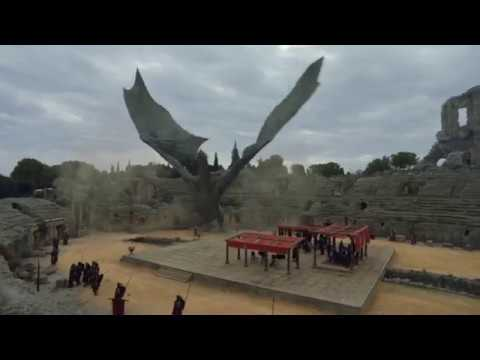

In [77]:
from IPython.display import YouTubeVideo
YouTubeVideo('aqZCD8Jn0pU')

## Detection and Recgnition

Based and Inspired by:
- **https://github.com/vudung45/FaceRec
- Augmentation code: https://github.com/vxy10/ImageAugmentation
- Fancy borders: https://www.codemade.io/fast-and-accurate-face-tracking-in-live-video-with-python/

Description:
- Images from Video Capture -> detect faces' regions -> crop those faces and align them 
- each cropped face is categorized in 3 types: Center, Left, Right 
- Extract 128D vectors( face features)
- Search for matching subjects in the dataset based on the types of face positions. 
- The preexisitng face 128D vector with the shortest distance to the 128D vector of the face on screen is most likely a match
(Distance threshold is 0.6, percentage threshold is 70%)
    

## Helper functions

In [78]:
def annotate_face(rect, recog_data, frame):
    """
    Draw a box around the face and label the person
    :param rect : the face bounding box
    :param recog_data : tuple of person name and confidence percentage (e.g: ('Jaime', 0.8))
    :param frame : the frame to draw on
    """
    shrtname = short_name(recog_data[0])
    acc = round(recog_data[1], 1)
    bbox_color = (255, 255, 255) if "Unknown" in recog_data[0] else (124,252,0)  # RGB

    #draw bounding box / fancy border for the face
    #cv2.rectangle(frame,(rect[0],rect[1]),(rect[0] + rect[2],rect[1]+rect[3]),bbox_color) 
    draw_border(frame, (rect[0],rect[1]), (rect[0] + rect[2],rect[1]+rect[3]), bbox_color, 1, 10, 10)  
    anot_text = shrtname + "-" + str(acc) + "%"
    cv2.putText(frame, anot_text,
                (rect[0]-4,rect[1]-4), cv2.FONT_HERSHEY_SIMPLEX,0.35,
                bbox_color, 1, cv2.LINE_AA)                        

    
def short_name(name):
    """e.g: Jaime Lannister -> Jaime.L"""
    if not name.startswith("Unknown"):
        name_split = name.split(" ")
        short_name = name_split[0]
        if len(name_split) > 1:
            short_name = short_name + "." + name_split[1][0]
        return(short_name)
    else:
        return name
    
    
def draw_border(img, pt1, pt2, color, thickness, r, d):
    """
    Fancy box drawing function by Dan Masek
    Code in: https://www.codemade.io/fast-and-accurate-face-tracking-in-live-video-with-python/
    """
    x1, y1 = pt1
    x2, y2 = pt2
 
    # Top left drawing
    cv2.line(img, (x1 + r, y1), (x1 + r + d, y1), color, thickness)
    cv2.line(img, (x1, y1 + r), (x1, y1 + r + d), color, thickness)
    cv2.ellipse(img, (x1 + r, y1 + r), (r, r), 180, 0, 90, color, thickness)
 
    # Top right drawing
    cv2.line(img, (x2 - r, y1), (x2 - r - d, y1), color, thickness)
    cv2.line(img, (x2, y1 + r), (x2, y1 + r + d), color, thickness)
    cv2.ellipse(img, (x2 - r, y1 + r), (r, r), 270, 0, 90, color, thickness)
 
    # Bottom left drawing
    cv2.line(img, (x1 + r, y2), (x1 + r + d, y2), color, thickness)
    cv2.line(img, (x1, y2 - r), (x1, y2 - r - d), color, thickness)
    cv2.ellipse(img, (x1 + r, y2 - r), (r, r), 90, 0, 90, color, thickness)
 
    # Bottom right drawing
    cv2.line(img, (x2 - r, y2), (x2 - r - d, y2), color, thickness)
    cv2.line(img, (x2, y2 - r), (x2, y2 - r - d), color, thickness)
    cv2.ellipse(img, (x2 - r, y2 - r), (r, r), 0, 0, 90, color, thickness) 
    
    
def read_image_from_url(url2read):
    if url2read.startswith('http') or url2read.startswith('data'):
        req = urllib.request.urlopen(url2read, timeout=5)
        arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
        img = cv2.imdecode(arr, -1) # 'Load it as it is'
    else:
        img = cv2.imread(url2read)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return(img)

## Detect Faces Using Haar Cascades

In [79]:
if not os.path.exists(os.path.join(rootdir_prefix, 'kaggle/working', 'haarcascade_frontalface_default.xml')):
    !wget https://github.com/opencv/opencv/raw/master/data/haarcascades/haarcascade_frontalface_default.xml -P /kaggle/working

In [80]:
#Create the haar cascade
face_cascade = cv2.CascadeClassifier(os.path.join(rootdir_prefix, 'kaggle/working', 'haarcascade_frontalface_default.xml'))

def find_faces_in_image(orig_img, scaleFactor, minNeighbors, minSize, maxSize):
    orig_img_copy = orig_img.copy()
    gray = cv2.cvtColor(orig_img_copy, cv2.COLOR_BGR2GRAY)
    #plt.imshow(gray) 
    
    # Detect faces in the image
    faces = face_cascade.detectMultiScale(
        gray,           
        scaleFactor=scaleFactor, 
        minNeighbors=minNeighbors,  
        minSize=minSize, 
        maxSize=maxSize 
    )
    
    print("Found {0} faces!".format(len(faces)))

    # Draw a rectangle around the faces
    for (x, y, w, h) in faces:
        cv2.rectangle(orig_img_copy, (x, y), (x+w, y+h), (0, 255, 0), 2)

    plt.imshow(orig_img_copy)

Found 1 faces!


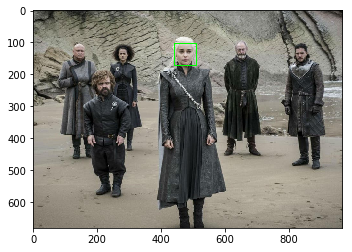

In [81]:
img  = read_image_from_url("https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/05/10/12/game-of-thrones-finale.jpg?w968h681")
scaleFactor = 1.3
minNeighbors = 5
minSize = (60, 60)   
maxSize = (70, 70)
find_faces_in_image(img, scaleFactor, minNeighbors, minSize, maxSize)

### Q1: Mini Assignemnt
Change paramaters of (scaleFactor, minNeighbors, minSize, maxSize) above to find all faces in the GOT image,
use information in: https://docs.opencv.org/2.4/modules/objdetect/doc/cascade_classification.html

Found 6 faces!


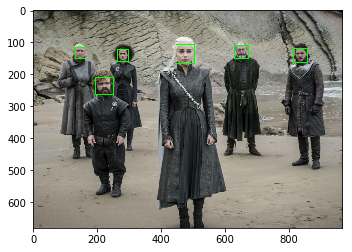

In [82]:
img  = read_image_from_url("https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/05/10/12/game-of-thrones-finale.jpg?w968h681")
scaleFactor = 1.08
minNeighbors = 3
minSize = (1, 1)   
maxSize = (60, 60)
find_faces_in_image(img, scaleFactor, minNeighbors, minSize, maxSize)

## Face Detection in Video using Haar

### Q2: Mini assignment
Complete the following find_faces_in_frame_of_video() function so we can do face detection on the video (tip: see find_faces_in_image() function above)

In [83]:
def find_faces_in_frame_of_video(frame, scaleFactor, minNeighbors, minSize, maxSize):
    """Find faces in an image and returns a list of (x, y, w, h) tuples (the bounding boxes of them)"""
    frame_copy = frame.copy()
    gray = cv2.cvtColor(frame_copy, cv2.COLOR_BGR2GRAY)
        
    # Detect faces in the image
    faces = face_cascade.detectMultiScale(
        gray,           
        scaleFactor=scaleFactor, 
        minNeighbors=minNeighbors,  
        minSize=minSize, 
        maxSize=maxSize 
    )
    for (x, y, w, h) in faces:
        cv2.rectangle(frame_copy, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
    plt.imshow(frame_copy)
    return faces

In [84]:
def video_file_recog_haar(src_filename, output_filename=rootdir_prefix+'kaggle/working/output_haar.mp4', framerate=None, scaleFactor=1.3, minNeighbors=5, minSize=60, maxSize=70):
    print("[INFO] Reading video file...")
    if glob.glob(src_filename):
        vs = cv2.VideoCapture(src_filename); #get input from file
    else:
        print("file does not exist")
        return
    
    print("[INFO] Initializing video writer...")
    frame_width = int(vs.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(vs.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(vs.get(cv2.CAP_PROP_FRAME_COUNT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') # DIVX, XVID, MJPG, X264, WMV1, WMV2, mp4v
    if framerate is None:
        framerate = vs.get(cv2.CAP_PROP_FPS) # use same as input video, or can set to 20.0 / 30.0
    out = cv2.VideoWriter(output_filename, fourcc, framerate, (frame_width,frame_height))
    
    recog_list = []
    frame_counter = 0
    t0 = time.time()
    while True:        
        ret, frame = vs.read();
        if ret:
            frame_counter += 1
            if frame_counter%(30/framerate)==0:
                min_face_size = 60 #min face size is set to 60x60
                rects = find_faces_in_frame_of_video(frame, scaleFactor, minNeighbors, (minSize, minSize), (maxSize,maxSize))
                print("\rNumber of faces found in frame " + str(frame_counter) + ":",len(rects), end='')
                aligns = []
                positions = []
                for (i, rect) in enumerate(rects):
                    draw_border(frame, (rect[0],rect[1]), (rect[0] + rect[2],rect[1]+rect[3]), (255,255,255), 1, 10, 10)
                    cv2.putText(frame,"Unknown",
                                        (rect[0]-4,rect[1]-4),cv2.FONT_HERSHEY_SIMPLEX,0.35,
                                        (255,255,255),1,cv2.LINE_AA)


                out.write(frame)
        else:  # end of video, no more frames
            break
    
    elapsed_time = time.time() - t0
    print()
    print("[exp msg] elapsed time for going over the video: " + str(time.strftime("%H:%M:%S", time.gmtime(elapsed_time))))
    vs.release()
    out.release()
    cv2.destroyAllWindows()
    print("Done")

[INFO] Reading video file...
[INFO] Initializing video writer...
Number of faces found in frame 3297: 1
[exp msg] elapsed time for going over the video: 00:00:15
Done


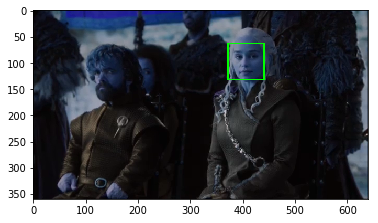

In [85]:
video_file_recog_haar(src_filename = get_file_path("Game of Thrones 7x07 - Epic Daenerys Dragonpit Entrance.mp4"), 
                      framerate=10,
                      scaleFactor=1.3,
                      minNeighbors=5,
                      minSize=60,
                      maxSize=70)

## Detect Faces Using MTCNN

### Full process stages overview:
- <b><u>Creating persons database (from google images) to compare our video faces to:</u></b>
    - Extract faces using MTCNN (replacing the Haar features we used earlier)
        - extracting from each frame the faces position and pose - center/left/right 
    - Augment images (synthetically creating more data)
    - Aligning the images (for better face comparing matches)
    - Feed faces to neural network to get 128D vector representation of the face (embeddings)
    - Store the results (person name, face pose, 128D vector) in a list of all persons
        - so later we will compare our video faces to that database


- <b><u>Go over video frame by frame:</u></b>
    - Extract faces using MTCNN
    - Aligning the images (for better face comparing matches)
    - Feed faces to neural network to get 128D vector representation of the face (embeddings)
    - Compare each face vector to the vectors we have in the faces database we created earlier to find the best match
        - if the match confidence (some distance metric) passes a chosen threshold then flag that face as the person we matched to

In [86]:
#Global Variables
person_embeddings = None

### Generate Faces Database functions
- Extract and crop faces from each given image
- convert faces to embedded vector of 128D

In [87]:
def augment_image(img):
    aug_images = []
    flip_img = cv2.flip(img, 1)  #https://docs.opencv.org/2.4/modules/core/doc/operations_on_arrays.html?highlight=flip#cv2.flip
    # for more example see https://github.com/aleju/imgaug
    aug_images.append(flip_img)
    return(aug_images)


def get_person_imgs(urls, min_face_size=40):
    """
    Given a list of URLs of a person images, this function will extract and align the faces within the image and detect its pose (left/right/center)
    """
    person_imgs = {"Left" : [], "Right": [], "Center": []};
    person_imgs_count = {"Left" : 0, "Right": 0, "Center": 0};
    
    counter_break = 0
    while True:    
        for url2read in urls:
            #print(file)
            #ret, frame = vs.read()
            #img = cv2.imread(file)
            img = read_image_from_url(url2read) # ****** file = url2read
            if img is None:
                print("********************* image was not loaded ***********************")
                continue

            # Augmenting the data - add a flipped version of the image to add more data
            frames = [img]
            frames.extend(augment_image(img))

            for frame in frames:
                if True: #ret:
                    rects, landmarks = face_detect.detect_face(frame, min_face_size)
                    #print("rects", rects)
                    for (i, rect) in enumerate(rects):
                        aligned_frame, pos = aligner.align(160, frame,landmarks[i]);
                        #print(pos)
                        person_imgs_count[pos]+=1
                        if len(aligned_frame) == 160 and len(aligned_frame[0]) == 160:
                            person_imgs[pos].append(aligned_frame)
                            #cv2.imshow("Captured face", aligned_frame)
                            #cv2.imwrite("../data2/frame%d.jpg" % count, aligned_frame)
                else:
                    break
            
        if person_imgs_count["Left"] == 0 or person_imgs_count["Right"] == 0 or person_imgs_count["Center"] == 0:
            counter_break+=1
            if counter_break > 0:
                print(person_imgs_count) 
                assert 0==1, "Must get all poses of a face: Left, Right and Center, try adding more images"
                return None
        else:
            break
                            
    print(person_imgs_count)    
    return(person_imgs)  

In [88]:
def extract_embeddings_from_images(min_face_size=40, embeddings_filename=rootdir_prefix+'kaggle/working/facerec_128D.txt'):
    """ 
    Go over all urls, extract and align faces, feed each face to the embeddings net,
    and saves an embedding vector for each person-position pair.
    Save all embeddings to a .txt file
    """
    print()
    print("[INFO] Extracting data from images ...")
    data_set = dict()

    for new_name in dict_faces.keys():
        person_features = {"Left" : [], "Right": [], "Center": []};
        print("Extracting:", new_name)
        print("number of img files:",len(dict_faces[new_name]))
        person_imgs = get_person_imgs(dict_faces[new_name], min_face_size=min_face_size) 
        if person_imgs is None:
            print("extraction of:",new_name, " failed")
            continue
        
        print("extracted person_imgs from:",new_name)
        print("-------------------------------------")

        for pos in person_imgs: # there are some exceptions here, but I'll just leave it as this to keep it simple
            person_features[pos] = [np.mean(extract_feature.get_features(person_imgs[pos]), axis=0).tolist()]
        data_set[new_name] = person_features;
    
    global person_embeddings
    person_embeddings = data_set
    with open(embeddings_filename, 'w+') as f:
        f.write(json.dumps(data_set))
    

def load_embeddings_from_file(embeddings_filename=rootdir_prefix+'kaggle/working/facerec_128D.txt'):
    global person_embeddings
    with open(embeddings_filename, 'r') as f:
        person_embeddings = json.loads(f.read());

        
def identifyPerson(features_arr, position, thres = 0.6, percent_thres = 70):
    '''
    :param features_arr: a list of 128d Features of a face
    :param position: face position types (Left/Right/Center)
    :param thres: distance threshold
    :param percent_thres : minimum confidence required to identify a person
    :return: tuple of person name and confidence of detection
    '''
    assert person_embeddings is not None, "Must load or extract persons embeddings in order to recgonize persons"
    result = "Unknown"
    smallest = sys.maxsize  # initialize with a large number
    for person in person_embeddings.keys():
        person_data = person_embeddings[person][position]
        for data in person_data:  # in our case there's only one embedding per person-position pair
            distance = scipy.spatial.distance.euclidean(data, features_arr)  # same as: np.sqrt(np.sum(np.square(data-features_arr)))
            #distance = scipy.spatial.distance.cosine(data, features_arr)  # if using cosine distance it is recommended to lower the thres to ~0.4
            
            if(distance < smallest):
                smallest = distance
                result = person
    percentage =  min(100, 100 * thres / smallest)
    if percentage <= percent_thres:
        result = "Unknown (%s)" % result.split(' ')[0]  # show highest score person for debug purposes
    return (result, percentage)

### Initialize

In [89]:
model_path = rootdir_prefix + 'kaggle/input/model-backup2/model-20170512-110547.ckpt-250000' 

In [90]:
# initalize
FRGraph = FaceRecGraph();
aligner = AlignCustom();
extract_feature = FaceFeature(FRGraph, model_path = model_path);
face_detect = MTCNNDetect(FRGraph, scale_factor=2); #scale_factor, rescales image for faster detection

Loading model...
Model loaded
Loading MTCNN Face detection model
MTCNN Model loaded


### Generate face database

# You can find more images yourself, otherwise, more images are available in Moodle

In [91]:
dict_faces = dict()
dict_faces["Jaime Lannister"] = ["https://s2.r29static.com//bin/entry/97f/340x408,85/1832698/image.jpg",
                                 "https://upload.wikimedia.org/wikipedia/en/thumb/b/b4/Jaime_Lannister-Nikolaj_Coster-Waldau.jpg/220px-Jaime_Lannister-Nikolaj_Coster-Waldau.jpg",
                                 "https://upload.wikimedia.org/wikipedia/pt/thumb/0/06/Nikolaj-Coster-Waldau-Game-of-Thrones.jpg/220px-Nikolaj-Coster-Waldau-Game-of-Thrones.jpg",
                                 "https://purewows3.imgix.net/images/articles/2017_09/jaime-lannister-season-7-game-of-thrones-finale1.jpg?auto=format,compress&cs=strip&fit=min&w=728&h=404",
                                 "https://cdn.newsday.com/polopoly_fs/1.13944684.1502107079!/httpImage/image.jpeg_gen/derivatives/landscape_768/image.jpeg",
                                 "https://www.cheatsheet.com/wp-content/uploads/2017/08/Jaime-Lannister-Game-of-Thrones.png",
                                 "https://fsmedia.imgix.net/9c/c0/27/10/15e0/44a4/8ecb/9339993b563d/nikolaj-coster-waldau-as-jaime-lannister-in-game-of-thrones-season-7.png?rect=0%2C0%2C1159%2C580&dpr=2&auto=format%2Ccompress&w=650",
                                 "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQrIQuBKKUocAizwfWtIdhAcvfowLJatKqqDsO3ywYdh3rv-mBk",
                                ]

dict_faces['Cersei Lannister'] = ['https://cdn.pastemagazine.com/www/articles/CERSEI-LANNISTER-quotes-list.jpg',
                                 'https://img1.looper.com/img/gallery/the-worst-things-cersei-lannister-has-ever-done/intro-1557760232.jpg',]


dict_faces['Tyrion Lannister'] = ['https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR4Re6vnUjEBxywRkRLrCmTMLf4YMWUF19GYS3cbKuRzVoTCz1d&s',
                                  'https://www.hbo.com/content/dam/hbodata/series/game-of-thrones/character/s5/tyrion-lannister-1920.jpg/_jcr_content/renditions/cq5dam.web.1200.675.jpeg',
                                  'https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/44ccdd999a4b20cdaef4696b8bf1a2c502db2b66f6909ae2a8a96a01a698370688e9b73dad75f0d33ea170c58a251155-1-1558322295.jpg?crop=0.668xw:1.00xh;0.0918xw,0&resize=480:*',
                                  'https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/theory-1553634761.jpg?crop=0.501xw:1.00xh;0,0&resize=480:*',
                                  'https://fromheartopaper.files.wordpress.com/2019/09/picsart_09-11-02.35.13.png?w=1080',
                                  'https://upload.wikimedia.org/wikipedia/en/thumb/5/50/Tyrion_Lannister-Peter_Dinklage.jpg/220px-Tyrion_Lannister-Peter_Dinklage.jpg']
dict_faces['Euron Greyjoy'] = ['http://assets.viewers-guide.hbo.com/small597a20afe7893@2x.jpg',
                                'http://static1.squarespace.com/static/52fc05c9e4b08fc45bd99090/5331dfe2e4b0f77da2ddde51/5cd9bdc8cdc8f30001b28a0c/1557848897813/cq5dam.web.1280.1280.jpeg?format=1500w',
                                'https://vignette.wikia.nocookie.net/gameofthrones/images/f/fc/Euron-Profile.PNG/revision/latest?cb=20170916200257',
                                'https://images.radiox.co.uk/images/52162?crop=16_9&width=660&relax=1&signature=k6BDCtKEIBn0Vy8EeqjdLe_JpaI=',
                                'https://cdn.vox-cdn.com/thumbor/iGnjL2BCwm_o_iyLu40Y00IjU_s=/0x0:2560x1394/1200x0/filters:focal(0x0:2560x1394):no_upscale()/cdn.vox-cdn.com/uploads/chorus_asset/file/16220189/Screen_Shot_2019_05_06_at_7.25.08_AM.png']
dict_faces['Qyburn'] = ['https://qph.fs.quoracdn.net/main-qimg-e2126ec618d9331d266d49eb09f2cf40.webp',
                        'https://qph.fs.quoracdn.net/main-qimg-53106ed4400757d745fef3da46dc02a1.webp',
                        'https://i.ytimg.com/vi/1Tsjj9o47n0/maxresdefault.jpg',
                        'https://i.redd.it/mm9sgp28ri811.jpg',
                        'https://vignette.wikia.nocookie.net/gameofthrones/images/2/2a/Qyburn_3x01.jpg/revision/latest/top-crop/width/300/height/300?cb=20130502025950',
                        'https://vignette.wikia.nocookie.net/gameofthrones/images/8/8a/804_Qyburn_Profile.png/revision/latest?cb=20190508024406']
dict_faces['Jon Snow'] = [
                        'https://images2.minutemediacdn.com/image/upload/c_crop,h_840,w_1500,x_0,y_6/f_auto,q_auto,w_1100/v1555003564/shape/mentalfloss/jon_snow_hed.jpg',
                        'https://d.newsweek.com/en/full/507446/jon-snow-game-thrones.jpg',
                        'https://www.indiewire.com/wp-content/uploads/2019/04/Helen-Sloan-HBO-4-copy.jpg?w=780',
                        'https://cdn.vox-cdn.com/thumbor/o2AXRjdoyonKroOEsxQjYWvtG-U=/99x0:1179x810/1200x800/filters:focal(99x0:1179x810)/cdn.vox-cdn.com/uploads/chorus_image/image/46094226/Jon_snow.0.jpg',
                        'https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/jon-snow-rhaegar-targaryen-1554321615.jpg?crop=0.482xw:0.962xh;0,0&resize=480:*',
                        'https://image.insider.com/5cb3c8e96afbee373d4f2b62?width=1100&format=jpeg&auto=webp',
                        'https://vignette.wikia.nocookie.net/gameofthrones/images/d/d0/JonSnow8x06.PNG/revision/latest?cb=20190714094440']
dict_faces['Davos Seaworth'] = ['https://newscast183978364.files.wordpress.com/2019/06/davos-seaworth-1.jpg?w=400&h=280&crop=1',                        
                                'https://amp.thenational.ae/image/policy:1.823364:1557570524/lf08-Feb-GoTPics.jpg?f=16x9&w=1200&$p$f$w=b6fcdf1',
                                'https://vignette.wikia.nocookie.net/p__/images/b/b0/Davos_Seaworth_2.jpg/revision/latest?cb=20170125224137&path-prefix=protagonist',
                                'https://vignette.wikia.nocookie.net/gameofthrones/images/9/9d/DAVOSINFOBOXBELLS.PNG/revision/latest?cb=20190513052340']

Checking: https://www.cheatsheet.com/wp-content/uploads/2017/08/Jaime-Lannister-Game-of-Thrones.png                                                                                                                
ERROR: Couldn't fetch https://www.cheatsheet.com/wp-content/uploads/2017/08/Jaime-Lannister-Game-of-Thrones.png, skipping this one
Checking: https://www.hbo.com/content/dam/hbodata/series/game-of-thrones/character/s5/tyrion-lannister-1920.jp                                                                                                     
ERROR: Couldn't fetch https://www.hbo.com/content/dam/hbodata/series/game-of-thrones/character/s5/tyrion-lannister-1920.jpg/_jcr_content/renditions/cq5dam.web.1200.675.jpeg, skipping this one
Checking: https://qph.fs.quoracdn.net/main-qimg-e2126ec618d9331d266d49eb09f2cf40.webp                                                                                                                              
ERROR: Couldn't fetch https://qph.fs.quor

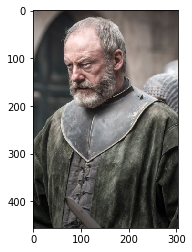

In [92]:
# Check urls and print last image
# if any image causes problems (like error 403 forbidden) it will remove it and choose another
for p in dict_faces.keys():
    urls = dict_faces[p]
    valid_urls = []
    for url2read in urls:
        print('\rChecking: %s' % url2read[:100], ' '*100, end='')
        try:
            img = read_image_from_url(url2read)
            valid_urls.append(url2read)
        except:
            print("\nERROR: Couldn't fetch %s, skipping this one" % url2read)
    dict_faces[p] = valid_urls
plt.imshow(img);

In [93]:
#load_embeddings_from_file()
extract_embeddings_from_images(min_face_size=40)


[INFO] Extracting data from images ...
Extracting: Jaime Lannister
number of img files: 7
{'Left': 4, 'Right': 6, 'Center': 5}
extracted person_imgs from: Jaime Lannister
-------------------------------------
Extracting: Cersei Lannister
number of img files: 2
{'Left': 1, 'Right': 1, 'Center': 2}
extracted person_imgs from: Cersei Lannister
-------------------------------------
Extracting: Tyrion Lannister
number of img files: 5
{'Left': 4, 'Right': 3, 'Center': 3}
extracted person_imgs from: Tyrion Lannister
-------------------------------------
Extracting: Euron Greyjoy
number of img files: 5
{'Left': 3, 'Right': 3, 'Center': 4}
extracted person_imgs from: Euron Greyjoy
-------------------------------------
Extracting: Qyburn
number of img files: 4
{'Left': 2, 'Right': 2, 'Center': 4}
extracted person_imgs from: Qyburn
-------------------------------------
Extracting: Jon Snow
number of img files: 7
{'Left': 5, 'Right': 3, 'Center': 6}
extracted person_imgs from: Jon Snow
----------

## Part by Part Walkthrough

### Face Detection

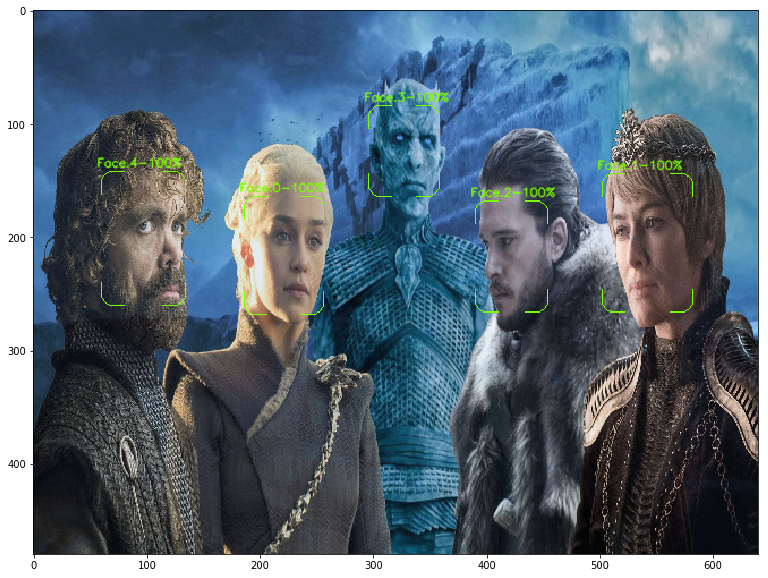

In [94]:
url = 'https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/best-game-of-thrones-season-8-fan-theories-1554917935.jpg'
frame = read_image_from_url(url)
frame = cv2.resize(frame, (640, 480))
rects, landmarks = face_detect.detect_face(frame, minsize=40);  # min face size is set to 80x80

for i, rect in enumerate(rects):
    #draw_border(frame, (rect[0],rect[1]), (rect[0] + rect[2],rect[1]+rect[3]), (255,255,255), 2, 10, 10)
    annotate_face(rect, ('Face %i' % i, 100), frame)
    
plt.subplots(figsize=(15,10))
plt.imshow(frame);

### Landmarks

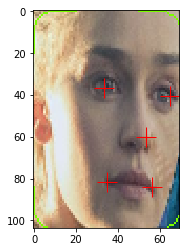

In [95]:
idx = 0
rect = rects[idx]
plt.imshow(frame[rect[1]:rect[1]+rect[3],rect[0]:rect[0]+rect[2]])
for k in range(int(len(landmarks[idx]) / 2)):
    plt.plot(landmarks[idx][k]-rect[0], landmarks[idx][k+5]-rect[1], 'r+', markersize=20)

### Align Face

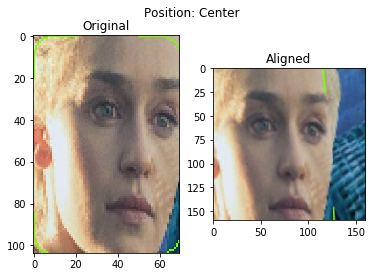

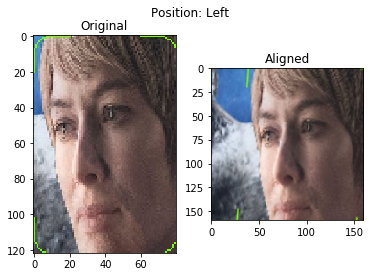

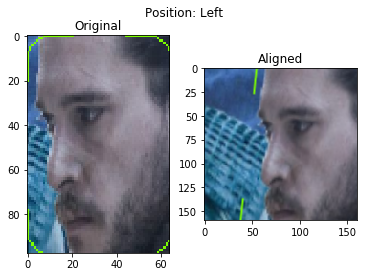

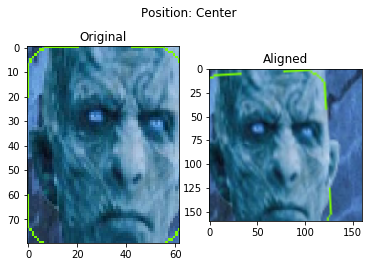

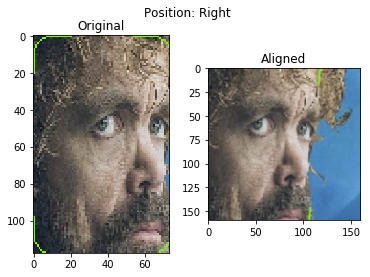

In [96]:
for (i, rect) in enumerate(rects):
    aligned_frame, pos = aligner.align(160, frame, landmarks[i])
    plt.subplot(121)
    plt.imshow(frame[rect[1]:rect[1]+rect[3],rect[0]:rect[0]+rect[2]])
    plt.title('Original')
    plt.subplot(122)
    plt.imshow(aligned_frame)
    plt.title('Aligned')
    plt.suptitle('Position: %s' % pos)
    plt.show()

### Feature extraction

In [97]:
features_vector = extract_feature.get_features([aligned_frame])

In [98]:
features_vector.shape

(1, 128)

In [99]:
features_vector

array([[-0.02162196, -0.04591966, -0.00532248,  0.07257378,  0.05850986,
        -0.03814613,  0.02719271,  0.05045392,  0.06412062,  0.06103019,
        -0.05970667,  0.01171595,  0.15436424, -0.03998298, -0.13833675,
         0.01996126,  0.11320244, -0.0887337 ,  0.04096926,  0.14024425,
         0.11793565,  0.0499902 ,  0.09765939,  0.0567503 ,  0.03358421,
        -0.03545899, -0.00941965,  0.02523636, -0.00793333,  0.07313781,
         0.00035429, -0.00959218, -0.03820315, -0.01400747,  0.03173051,
        -0.0888781 , -0.07958167,  0.04815311, -0.05374043,  0.12489448,
        -0.05932627,  0.10580063, -0.02976254,  0.14383645, -0.03996062,
         0.07400405,  0.02631844,  0.00682812, -0.11867873,  0.0684782 ,
        -0.15123689,  0.12382424, -0.07749039, -0.04896725, -0.11701677,
        -0.0622286 ,  0.17006597,  0.02911503, -0.32386813, -0.08275804,
        -0.00487188,  0.03491944, -0.11925371, -0.06567978, -0.15009283,
        -0.042159  ,  0.06876367,  0.05381718,  0.0

## Face Recognition in Video using MTCNN, aligner and embedded vectors

### Q3 Mini assignment
Complete the following frame_face_recog() function so we can do face detection on the video
 - Detect all faces in frame and get their bounding-rectangles and landmarks using face_detect.detect_face() function
 - Go through each face bounding box in the frame and perform for each one:
    - align the face (using aligner.align() function). remember that aligner.align() returns the aligned-face and face-pose (left/right/center) that you'll need for identifyPerson() function
    - extract aligned face features (embeddings) using extract_feature.get_features() function. (make sure you pass the function a list object, just wrap the input with [ ]
    - find the person the face belongs to using identifyPerson() function.
    - draw a box around the face and label the person using annotate_face() function

In [100]:
def frame_face_recog(frame, min_face_size=80, percent_thres = 70, verbose=False):
    """ 
    Detect faces in a frame, try to recgonize them, and draws a box around the face with predicted person + % confidence
    :param frame : the frame to indentify faces in. an array with shape of width X height X channels
    :param min_face_size : minimum size of face to detect. integer. e.g: value of 80 is set to 80x80 pixels
    :param verbose : True to print debug information while running
    
    Alters inplace the frame with predictions annotations
    returns a list of (person,confidence) tuples
    """
    
    # Detect all faces in frame and get their bounding-rectangles and landmarks
    rects, landmarks = face_detect.detect_face(frame, minsize=40);  # min face size is set to 80x80
    
    # Go through each face in frame and perform:
    recog_list = []
    for i, currRect in enumerate(rects):
        if verbose: print('BBox %i:' % i, end=' ')
        #  1) align the face (using aligner.align() function). remember that aligner.align() returns the aligned-face and face-pose (left/right/center)
        aligned_face, face_pos = aligner.align(160, frame, landmarks[i])
        #  2) extract aligned face features (embeddings)
        features_arr = extract_feature.get_features([aligned_face])
        #  3) find the person the face belongs to
        recog_data = identifyPerson(features_arr, face_pos)
        recog_list.append(recog_data)
        if verbose: print("recog_data", str(recog_data))
        #  4) draw a box around the face and label the person
        annotate_face(currRect, ('Face %i' % i, 100), frame)
            
    return recog_list

### Test your function

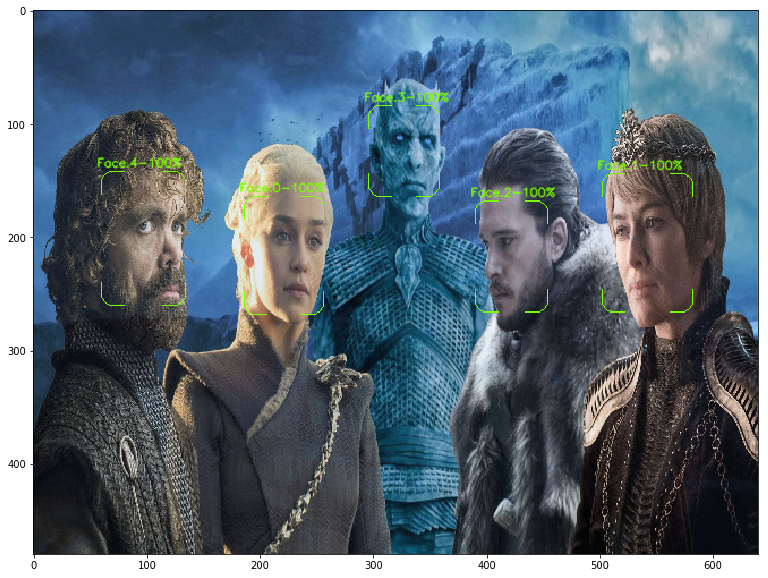

In [101]:
url = 'https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/best-game-of-thrones-season-8-fan-theories-1554917935.jpg'
frame = read_image_from_url(url)
frame = cv2.resize(frame, (640, 480))
frame_face_recog(frame, min_face_size=80, percent_thres = 70)
plt.subplots(figsize=(15,10))
plt.imshow(frame);

In [102]:
def video_file_recog(src_filename, output_filename=rootdir_prefix+'kaggle/working/output.mp4', percent_thres = 70, verbose=False):
    print("[INFO] Reading video file...")
    if glob.glob(src_filename):
        vs = cv2.VideoCapture(src_filename); #get input from file
    else:
        print("file does not exist")
        return
    
    print("[INFO] Initializing video writer...")
    frame_width = int(vs.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(vs.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(vs.get(cv2.CAP_PROP_FRAME_COUNT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') # DIVX, XVID, MJPG, X264, WMV1, WMV2, mp4v
    framerate = vs.get(cv2.CAP_PROP_FPS) # use same as input video, or can set to 20.0 / 30.0
    out = cv2.VideoWriter(output_filename, fourcc, framerate, (frame_width,frame_height))
    
    recog_list = []
    frame_counter = 0
    t0 = time.time()
    while True:        
        ret, frame = vs.read();
        if ret:
            frame_counter += 1
            print('\rProcessing Frame %i/%i' % (frame_counter, total_frames), end=' ')
            recog_data = frame_face_recog(frame, min_face_size=40, percent_thres=percent_thres, verbose=verbose)
            recog_list.extend(recog_data)
            #cv2.imshow("Frame",frame)
            #cv2.imwrite("../data3/frame%d.jpg" % count, frame)
            out.write(frame)
        else:  # end of video, no more frames
            break
    
    elapsed_time = time.time() - t0
    print()
    print("[exp msg] elapsed time for going over the video: " + str(time.strftime("%H:%M:%S", time.gmtime(elapsed_time))))
    vs.release()
    out.release()
    cv2.destroyAllWindows()
    
    known_counter = len([1 for recog in recog_list if recog[1] > percent_thres])
    unknown_counter = len(recog_list) - known_counter
    print("known_counter:", known_counter, "unknown_counter:", unknown_counter)
    
    print()
    print("Done")

### RUN Video generation

In [103]:
video_file_recog(src_filename = get_file_path("Game of Thrones 7x07 - Epic Daenerys Dragonpit Entrance.mp4"), percent_thres=70, verbose=False)

[INFO] Reading video file...
[INFO] Initializing video writer...
Processing Frame 3297/3297  
[exp msg] elapsed time for going over the video: 00:02:59
known_counter: 373 unknown_counter: 716

Done


In [104]:
# the output file from opencv is just video frames (Without audio). lets add the original audio track to the output movie
# if ffmpeg is not installed then it will return False
#vid2vid_audio_transfer('Game of Thrones 7x07 - Epic Daenerys Dragonpit Entrance.mp4', 'output.mp4', 'output_w_audio.mp4');

In [105]:
!ls ../working/ -ashl

total 26M
4.0K drwxr-xr-x 2 root root 4.0K Dec 31 19:02 .
4.0K drwxr-xr-x 5 root root 4.0K Dec 31 18:59 ..
4.0K ---------- 1 root root  263 Dec 31 18:59 __notebook_source__.ipynb
 60K -rw-r--r-- 1 root root  58K Dec 31 19:22 facerec_128D.txt
912K -rw-r--r-- 1 root root 909K Dec 31 19:01 haarcascade_frontalface_default.xml
 17M -rw-r--r-- 1 root root  17M Dec 31 19:25 output.mp4
8.2M -rw-r--r-- 1 root root 8.2M Dec 31 19:22 output_haar.mp4


## Questions and Instructions - part 1. Not for **submission**

### Haar Cascade
- Change paramaters of (scaleFactor, minNeighbors, minSize, maxSize) to find all faces in the GOT image, using find_faces_in_image().
    - gray is the input grayscale image.
    - scaleFactor is the parameter specifying how much the image size is reduced at each image scale. It is used to create the scale pyramid.
    - minNeighbors is a parameter specifying how many neighbors each candidate rectangle should have, to retain it. A higher number gives 
      lower false   positives.
    - minSize is the minimum rectangle size to be considered a face.
    - More help can be found in: https://docs.opencv.org/2.4/modules/objdetect/doc/cascade_classification.html
- Which parameters did the best work?
- complete function find_faces_in_frame_of_video() to run face detection using  video_file_recog_haar() on the GOT video
-  Change paramaters of (scaleFactor, minNeighbors, minSize, maxSize) to find as many TRUE faces as possible in video using
    video_file_recog_haar()
    - To download output video file (output_haar.mp4): click on the download icon near its name in the right pane. click once and wait, as sometimes it takes it a bit of time to process the download.
    - Which parameters did the best work?
- Check your parameters with framerate of 30 when you think it is good enough

### MTCNN and Face Vector Search
- Do mini-assignment and complete frame_face_recog() function
- Run video_file_recog() to create the output movie (code already there, just need to run it)
- Download movie output.mp4 and check who was recognized and how many times?
- Add more individulas to the database so you could recgnize more individuals in video (notice you need images with center, right, left angles)
- What led you to choose the images you chose? what was your thought process?
- Try to augment the images using the augment_image function, does that improves the accuracy?
   - For help check opencv image manipulaions and https://github.com/aleju/imgaug
- Try to change min_face_size and see if you can recgnize faces in more frames
- How would you increase the accuracy of the recognition?
- How would you increase the consistency of the recognition (like when the same face is recognized in one frame and not in the next)?
- How would you make the entire process run faster?
- what will happen if we will reshape the face images (that the aligner returns) to something other than 160x160 pixels?
- what should you do if you want to methodically test your model on the given video file?
- in second 55, Cersei isn't recognized well? which images you should include in person-images to improve that?

----------------

# Part 2 - Super Resolution

- OBJECTIVE - reconstruct a face from a low resolution image

![example](https://github.com/tadax/srgan/raw/master/results/000000010.jpg)

Heavily based on https://github.com/tadax/srgan, which is an implementation of the SRGAN model proposed in the paper (Photo-Realistic Single Image Super-Resolution Using a Generative Adversarial Network, https://arxiv.org/abs/1609.04802) with TensorFlow.  
Trained on Labeled Faces in the Wild - http://vis-www.cs.umass.edu/lfw/

## Setup and main functions

In [106]:
from dsClass.srganUnified import SRGAN
import tensorflow as tf

In [107]:
def infer(x_test, ground_truth, titles, save_results=False, display=True, model_file=rootdir_prefix+'kaggle/input/srgan-models-tutorial/srganA-epoch300'):
    """ x_test should be in shape of (batch_size, 24, 24, 3). images in BGR (not RGB)
    and ground_truth is same as x_test, just (batch_size, 96, 96, 3)
    ground_truth is only used for displaying, and not for inferring.
    """
    x = tf.placeholder(tf.float32, [None, 24, 24, 3])
    is_training = tf.placeholder(tf.bool, [])

    print('Initializing Model')
    model = SRGAN(x, is_training, batch_size=len(x_test), infer=True)

    print('Loading model checkpoint')
    # Restore the SRGAN network
    saver = tf.train.Saver()
    saver.restore(sess, model_file)

    print('Inferring')
    # Infer
    raw = x_test.astype('float32')
    fake = sess.run(
        model.imitation,
        feed_dict={x: raw, is_training: False})
    save_img([raw, fake, ground_truth], ['Input', 'Output', 'Ground Truth'], titles, save=save_results, display=display)
    print('Done')

    
def save_img(imgs, label, titles, save=False, display=True):
    for i in range(len(imgs[0])):
        seq_ = "{0:04d}".format(i+1)
        fig = plt.figure()
        for j, img in enumerate(imgs):
            im = np.uint8((img[i]+1)*127.5)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            fig.add_subplot(1, len(imgs), j+1)
            plt.imshow(im)
            plt.tick_params(labelbottom='off')
            plt.tick_params(labelleft='off')
            plt.gca().get_xaxis().set_ticks_position('none')
            plt.gca().get_yaxis().set_ticks_position('none')
            plt.xlabel(label[j])
            if j==1:
                plt.title(titles[i])
    
        path = os.path.join('result', '{}.jpg'.format(titles[i]))
        if save:
            plt.savefig(path)
        if display:
            plt.show()
        if save:
            plt.close()

In [108]:
def downscale_func(x):
        if len(x.shape)==3:
            x = np.expand_dims(x, axis=0)
        K = 4
        arr = np.zeros([K, K, 3, 3])
        arr[:, :, 0, 0] = 1.0 / K ** 2
        arr[:, :, 1, 1] = 1.0 / K ** 2
        arr[:, :, 2, 2] = 1.0 / K ** 2
        weight = tf.constant(arr, dtype=tf.float32)
        downscaled = tf.nn.conv2d(
            x, weight, strides=[1, K, K, 1], padding='SAME')
        return downscaled


def process_file(filename, downscale='cv2'):
    """ downscale can be 'cv2' / 'conv' 
    """
    img = cv2.imread(filename)
    return process_img_arr(img[:,:,::-1], filename, downscale)


def process_img_arr(img, name, downscale='cv2'):
    face = img[:,:,::-1].copy()
      
    if face.shape[0] > 96:
        ground_truth = cv2.resize(face, (96, 96))
    else:
        ground_truth = face
    
    if downscale=='cv2':
        face = cv2.resize(face, (24, 24))
    elif downscale=='conv':
        gt4conv = cv2.resize(face, (96, 96))
        downs = downscale_func(gt4conv.astype('float32'))
        face = sess.run(downs)
    
    ground_truth = ground_truth / 127.5 - 1
    face = face / 127.5 - 1
    input_ = np.zeros((1, 24, 24, 3))
    input_[0] = face
    
    return input_, ground_truth

## Fetching the data
feed in urls of images of faces

In [109]:
face_urls = [
             rootdir_prefix+'kaggle/input/srgan-models-tutorial/srgan-pic1.jpg',
             rootdir_prefix+'kaggle/input/srgan-models-tutorial/srgan-pic2.jpg',
             rootdir_prefix+'kaggle/input/srgan-models-tutorial/srgan-pic3.jpg',
             'https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/best-game-of-thrones-season-8-fan-theories-1554917935.jpg',
             'https://i.redd.it/mm9sgp28ri811.jpg',
             'https://cdn.pastemagazine.com/www/articles/CERSEI-LANNISTER-quotes-list.jpg',
]

## Q4: Mini assignment
Complete the following urls2imgarr() function.  
use the face detection methods you've used in part 1

In [110]:
def urls2imgarr(urls, crop_faces=True):
    """ 
    Go over all urls. for each url, fetch the image, and if crop_faces is True then extract and crop all faces in image.
    returns a list of image arrays. each item in the list is of shape of (width, height, 3). width and height of images can vary, they will be resized later on in process_img_arr()
    """
    all_faces = []
    for url in face_urls:
        print('Fetching', url)
        frame = read_image_from_url(url)
        #frame = cv2.resize(frame, (640, 480))
        if crop_faces:
            rects, _ =  face_detect.detect_face(frame, minsize=40);
            for (i, rect) in enumerate(rects):
                img_arr = frame[rect[1]:rect[1]+rect[3],rect[0]:rect[0]+rect[2]]
                all_faces.append(img_arr)
        else:
            all_faces.append(frame)
    print('Done.')
    return all_faces

all_faces = urls2imgarr(face_urls, crop_faces=True)
print('Fetched total of %i faces' % len(all_faces))

Fetching /kaggle/input/srgan-models-tutorial/srgan-pic1.jpg
Fetching /kaggle/input/srgan-models-tutorial/srgan-pic2.jpg
Fetching /kaggle/input/srgan-models-tutorial/srgan-pic3.jpg
Fetching https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/best-game-of-thrones-season-8-fan-theories-1554917935.jpg
Fetching https://i.redd.it/mm9sgp28ri811.jpg
Fetching https://cdn.pastemagazine.com/www/articles/CERSEI-LANNISTER-quotes-list.jpg
Done.
Fetched total of 10 faces


## RUN

In [111]:
tf.reset_default_graph()
sess = tf.Session()
init = tf.global_variables_initializer() 
sess.run(init)

x_test = []
ground_truth = []
titles = []
for (i, img_arr) in enumerate(all_faces):
    x, gt = process_img_arr(img_arr, i, downscale='conv')
    x_test.append(x)
    ground_truth.append(gt)
    titles.append(i)

x_test = np.concatenate(x_test)

In [112]:
x_test.shape

(10, 24, 24, 3)

Initializing Model
Loading model checkpoint
Inferring


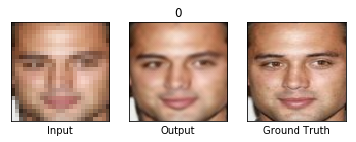

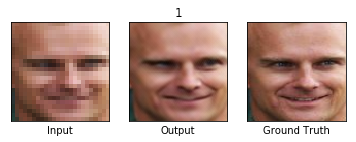

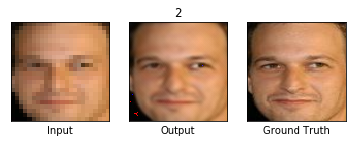

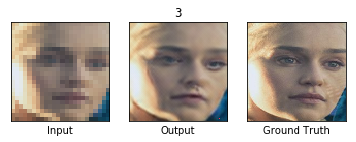

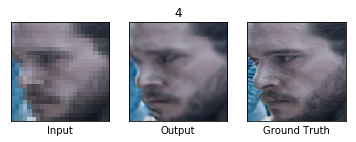

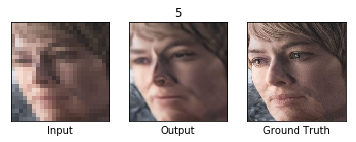

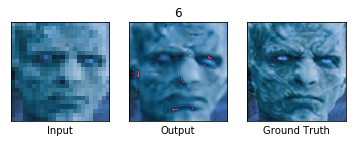

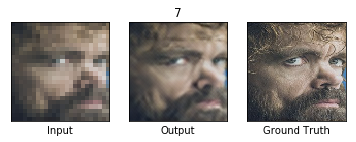

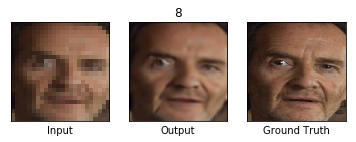

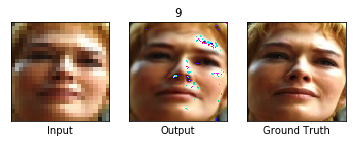

Done


In [113]:
tf.reset_default_graph()
sess = tf.Session()
init = tf.global_variables_initializer() 
sess.run(init)

infer(x_test, ground_truth, titles, save_results=False, display=True, model_file=rootdir_prefix+'kaggle/input/srgan-models-tutorial/srganA-epoch300')

Initializing Model
Loading model checkpoint
Inferring


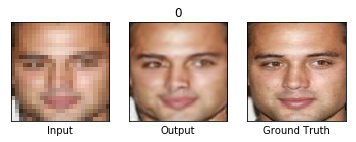

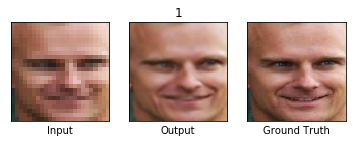

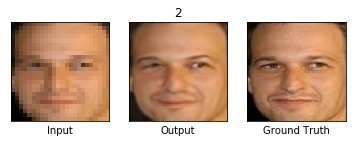

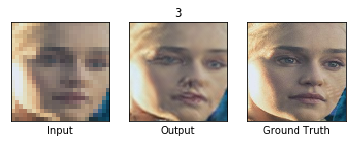

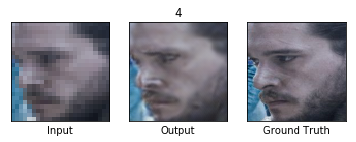

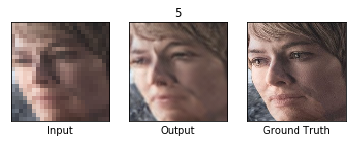

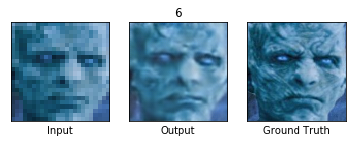

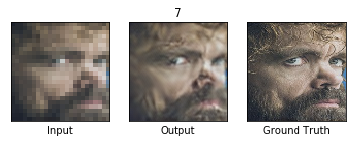

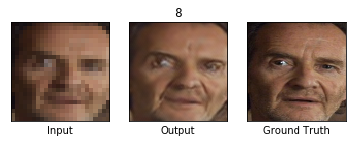

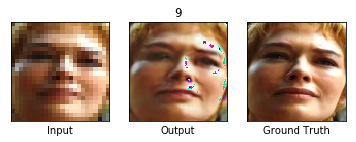

Done


In [114]:
tf.reset_default_graph()
sess = tf.Session()
init = tf.global_variables_initializer() 
sess.run(init)

infer(x_test, ground_truth, titles, save_results=False, display=True, model_file=rootdir_prefix+'kaggle/input/srgan-models-tutorial/srganB-epoch300')

## Questions and Instructions - Part 2

- Complete urls2imgarr() function. use the face detection methods you've used in part 1.

- Go to Labeled Faces in the Wild website and inspect it a bit (http://vis-www.cs.umass.edu/lfw/)
  - Q5: What are the caveats of this dataset and what we should look out for when using it?
  
- run the inference one time with 'srganA-epoch300' as the model_file, and again with 'srganB-epoch300'
  - Q6: both srganA and srganB models have the same architechture. What do you think is the difference between them?
  
### Choose 2 question from Q7 to Q10 and Answer them. Answer the mandatory questions Q11 and Q12. ###
    - Q7: What happens when we are not cropping the images to only the faces? Why?
    - Q8: Which downscaling method brings better results ('conv' or 'cv2')? why do the downscaling method affects the performance of the model?
    - Q9: How many faces were identified using the algorithm in part 1? - 
    - Q10: Suggest a way to improve the detection rate of the images that came from the superresolution model.

- Q11: Explain how the triplet loss works. How can we optimize it properly?
- Q12: What are the main CNNs in the MTCNN algorithm? What are the differences between them?


# Answers



5) Some of the caveats:
- There may be a bias in the selection of photos for this database (not enough people of color / different ethnicity
- There may not be enough "extreme" photos (like bad lightning, noises, poses)

We need to make sure that we have a varity of different photos so the model could be traind without bias.

6) Maybe the differnce between them can be:
- differnt training samples were given to them
- The data could be the same, but in different order and that will impact the weights
- the model created different weights for each connection 

7) The model will analyze alot of things he shouldnt deal with,(like hands and torso). Also it will analyze alot more pixels which will increase computational time. The enviorment can affect the model prediction and it shouldn't do that (like we saw in the wolf prediction, the model thought that if we have snow in the background than the animal is a wolf) 


10) Ways we can improve:
- One way we can improve the detection rate is to give the model more examples to train on!, If the model will see more examples maybe he will notice more features that he did before and will detect better.
- We can try to give him images with more noises.


11) we use 3 pictures - anchor, positive and negative (anchor and pos are one person in 2 pictures and negative is another person), and we want the distance between (anchor - positive) - (anchor - negative) + alpha to be 0. We want to maximize the distance between differnt people's photos and minimize the distance between the same person in 2 photos.

Optimizations: 
- we can determine the negative to be a person that look alike the first person but is not him (like chad smith and will ferrel). if we give a totally different looking person as the negative, the loss would be achived faster (they already have far distance from each other).
- Use stochastic gradient descent (its an optimization for gradient descent, it's quicker).


12)
- P-Net = shallow CNN , his job is to generate candidate regions where face might be.
- R-Net = complex CNN , his job is to filter and refine windows created by the first CNN using NMS (predicting the bounding box coordinates for each face).
- O-Net = complex CNN , his job is to find box with face and facial features.

The difference between them is the size and the comlexity of them. the first one is small and "simple" but the other two are big and more comlex.